In [2]:
# NOT COMPLETED
## not yet detecting outer boundary correctly

import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_laplace, sobel

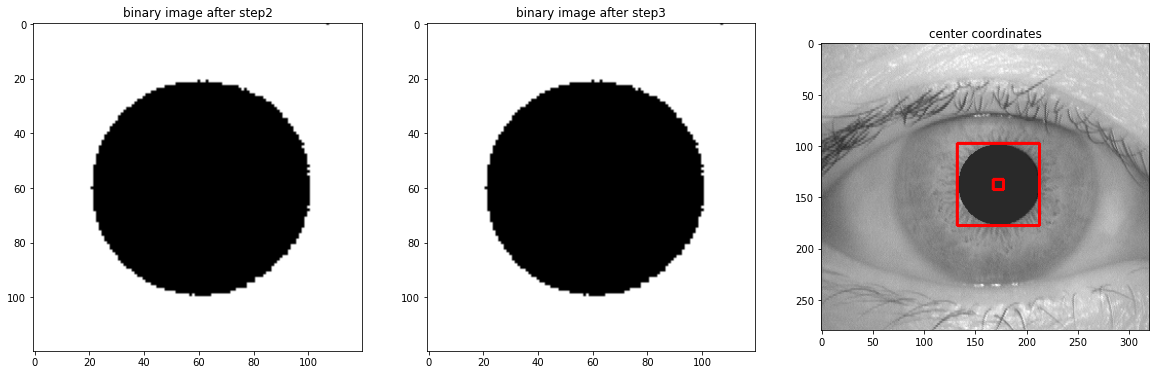

In [24]:
'''
Detecting pupil and outer boundary of iris.
You can choose other iris localization methods if they work better.
'''

path = 'CASIA Iris Image Database (version 1.0)/001/1'
image_file = os.path.join(path, '001_1_2.bmp')
image = cv2.imread(image_file)
img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# define a function for projection profile because of repeatitive use
def projectionProfile(image, xp, yp, width, height):
    '''
    image: target image
    xp, yp: center point used when trimming the target image 
    width, height: width and height in which we want to trimming the target image
    '''
    w = int(width/2)
    h = int(height/2)
    # trim the target image 
    img = image[yp-h:yp+h, xp-w:xp+w]

    # create the binary image
    _,img_binary = cv2.threshold(img, 70, 255, cv2.THRESH_BINARY)

    # implement projection profile 
    vertical = img_binary.sum(axis=0)
    horizontal = img_binary.sum(axis=1)

    # find a coordinate whose procection profiles are minima
    x_p = np.argmin(vertical) + xp - w
    y_p = np.argmin(horizontal) + yp - h

    return x_p, y_p, img_binary


# projection profiles to find the center coordinates of a pupil (STEP1)
x_p, y_p, _ = projectionProfile(img_gray, 160, 140, 320, 280)

# update the center coordinate of the pupil (STEP2)
## create binary image around the pupil
x_p2, y_p2, img_bi2 = projectionProfile(img_gray, x_p, y_p, 120, 120)

# update again for accuracy (STEP3)
x_p3, y_p3, img_bi3 = projectionProfile(img_gray, x_p2, y_p2, 120, 120)

# calculate radius of inner boundary (pupil)
minx = x_p3 - x_p2 + 60
miny = y_p3 - y_p2 + 60

mask = np.where(img_bi3>0, 1, 0)

# let radius be the average of predicted radius along vertical and horizontal directions
radius_x = (120 - sum(mask[minx])) / 2
radius_y = (120 - sum(mask[miny])) / 2
radius = int((radius_x + radius_y) / 2)


# Check the position of the center coordinate
# STEP1 Blue
img_rectangle = cv2.rectangle(
                img_rgb,(x_p-5,y_p-5),(x_p+5,y_p+5),(0,0,255),2
                )
# STEP2 Green
img_rectangle = cv2.rectangle(
                img_rectangle,(x_p2-5,y_p2-5),(x_p2+5,y_p2+5),(0,255,0),2
                )
# STEP3 Red
img_rectangle = cv2.rectangle(
                img_rectangle,(x_p3-5,y_p3-5),(x_p3+5,y_p3+5),(255,0,0),2
                )
img_rectangle = cv2.rectangle(
                img_rectangle,(x_p3-radius,y_p3-radius),(x_p3+radius,y_p3+radius),(255,0,0),2
                )

plt.figure(figsize=(20,16))
plt.subplot(1, 3, 1)
plt.imshow(img_bi2, cmap='gray')
plt.title('binary image after step2')

plt.subplot(1, 3, 2)
plt.imshow(img_bi3, cmap='gray')
plt.title('binary image after step3')

plt.subplot(1, 3, 3)
plt.imshow(img_rectangle)
plt.title('center coordinates')

plt.show()


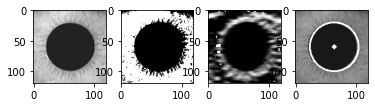

In [25]:
# detect inner boundary (pupil) using Hough Transform

# narrow down the image not to detect wrong circles
img_120 = img_gray[y_p3-60:y_p3+60, x_p3-60:x_p3+60]
_,img_bi = cv2.threshold(img_120, 127, 255, cv2.THRESH_BINARY)

# use edge image so that detect iris correctly
img_edge = gaussian_laplace(img_bi, sigma=3)

# apply Hough Transform
mind = 10000
for i in range(1,5):
    circles_in = cv2.HoughCircles(img_edge,cv2.HOUGH_GRADIENT,1,100,
                            param1=50,param2=10,minRadius=radius-i,maxRadius=radius+i)
    if type(circles_in) != type(None):
        d = np.sqrt((circles_in[0,0,0] - x_p3)**2 + (circles_in[0,0,1] - y_p3)**2 + (circles_in[0,0,2] - radius)**2)
        if mind > d: # find nearest circle if it has several candidates
            mind = d
            innercircle = circles_in

innercircle = np.uint16(np.around(innercircle[0]))

# check the detection for inner boundary

# draw inner circle
img_incircle = img_120.copy()

for i in innercircle:
    cv2.circle(img_incircle,(i[0],i[1]),i[2],255,2)
    cv2.circle(img_incircle,(i[0],i[1]),2,255,3)

# show images
plt.subplot(1, 4, 1)
plt.imshow(img_120, cmap='gray')

plt.subplot(1, 4, 2)
plt.imshow(img_bi, cmap='gray')

plt.subplot(1, 4, 3)
plt.imshow(img_edge, cmap='gray')

plt.subplot(1, 4, 4)
plt.imshow(img_incircle, cmap='gray')

plt.show()

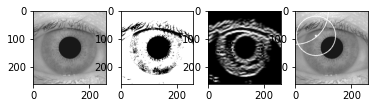

In [26]:
# detect outer boundary using Hough transform

# narrow down the image not to detect wrong circles
img_260 = img_gray[y_p3-130:y_p3+130, x_p3-130:x_p3+130]
_,img_bi2 = cv2.threshold(img_260, 127, 255, cv2.THRESH_BINARY)

# use edge image so that detect iris correctly
img_edge2 = gaussian_laplace(img_bi2, sigma=3)

# apply Hough Transform
mind = 10000
for i in range(1,5):
    circles_out = cv2.HoughCircles(img_edge,cv2.HOUGH_GRADIENT,1,100,
                            param1=50,param2=10,minRadius=70,maxRadius=120)
    if type(circles_out) != type(None):
        d = np.sqrt((circles_in[0,0,0] - x_p3)**2 + (circles_in[0,0,1] - y_p3)**2)
        if mind > d: # find nearest circle if it has several candidates
            mind = d
            outercircle = circles_out

outercircle = np.uint16(np.around(outercircle[0]))


# check the detection for outer boundary
# draw outer circle
img_outcircle = img_260.copy()

for i in outercircle:
    cv2.circle(img_outcircle,(i[0],i[1]),i[2],255,2)
    cv2.circle(img_outcircle,(i[0],i[1]),2,255,3)

plt.subplot(1, 4, 1)
plt.imshow(img_260, cmap='gray')

plt.subplot(1, 4, 2)
plt.imshow(img_bi2, cmap='gray')

plt.subplot(1, 4, 3)
plt.imshow(img_edge2, cmap='gray')

plt.subplot(1, 4, 4)
plt.imshow(img_outcircle, cmap='gray')

plt.show()
